# ACL 
We download the entire ACL database bib file. We then manually add entries from the most recent issue as this one is not in the database.

In [1]:
import pandas as pd
import numpy as np

In [12]:
# https://bibtexparser.readthedocs.io/en/master/index.html
pip install bibtexparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bibtexparser: filename=bibtexparser-1.2.0-py3-none-any.whl size=36713 sha256=f1d07ae8b9825dec7f318d7f9d323e3021ca6140bc8dee039b95b32e8353a120
  Stored in directory: /Users/kylehamilton/Library/Caches/pip/wheels/3e/13/1d/09c37a40f39ddd7b226719a797f1896a5b95d730de27e7a505
Successfully built bibtexparser
Note: you may need to restart the kernel to use updated packages.


In [20]:
# with open("../../ACL/anthology+abstracts.bib") as bibtex_file:
#     bib_database = bibtexparser.load(bibtex_file)
    
# df = pd.DataFrame(bib_database.entries)
# # selection = df[['doi', 'number']]
# # selection.to_csv('temp.csv', index=False)

In [19]:
import bibtexparser
from bibtexparser.bparser import BibTexParser

with open('../../ACL/anthology+abstracts.bib') as bibtex_file:
    bibtex_str = bibtex_file.read()
    
parser = BibTexParser(common_strings=True)
parser.ignore_nonstandard_types = True
parser.homogenise_fields = True

bib_database = bibtexparser.loads(bibtex_str, parser)

In [99]:
df = pd.DataFrame(bib_database.entries)

### Add 2022 entries

In [100]:
acl22 = pd.read_csv('../../ACL/ACL-2022.csv')

In [101]:
acl22.columns

Index(['url', 'publisher', 'address', 'year', 'month', 'editor', 'title',
       'ENTRYTYPE', 'ID', 'pages', 'booktitle', 'author', 'abstract', 'doi',
       'volume', 'journal', 'language', 'number', 'isbn', 'note'],
      dtype='object')

In [102]:
df = pd.concat([df,acl22])

In [103]:
df.to_csv('../../ACL/anthology+abstracts.csv',index=None)

# START HERE

In [65]:
df = pd.read_csv('../../ACL/anthology+abstracts.csv')

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (14,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
len(df)

74585

In [67]:
df.columns

Index(['url', 'publisher', 'address', 'year', 'month', 'editor', 'title',
       'ENTRYTYPE', 'ID', 'pages', 'booktitle', 'author', 'abstract', 'doi',
       'volume', 'journal', 'language', 'number', 'isbn', 'note'],
      dtype='object')

In [68]:
df.dtypes

url          object
publisher    object
address      object
year          int64
month        object
editor       object
title        object
ENTRYTYPE    object
ID           object
pages        object
booktitle    object
author       object
abstract     object
doi          object
volume       object
journal      object
language     object
number       object
isbn         object
note         object
dtype: object

In [69]:
df.journal.unique()

array([nan,
       'Transactions of the Association for Computational Linguistics',
       'Computational Linguistics',
       'American Journal of Computational Linguistics'], dtype=object)

In [70]:
df.journal.value_counts()

Computational Linguistics                                        1733
Transactions of the Association for Computational Linguistics     444
American Journal of Computational Linguistics                     368
Name: journal, dtype: int64

In [71]:
df.ENTRYTYPE.value_counts()

inproceedings    69990
article           2538
proceedings       2050
Name: ENTRYTYPE, dtype: int64

In [73]:
# quick sanity check
txt = "Towards a Model-Theoretic View of Narratives"
df[df.title.str.contains(txt)]

,url,publisher,address,year,month,editor,title,ENTRYTYPE,ID,pages,booktitle,author,abstract,doi,volume,journal,language,number,isbn,note
1514,https://aclanthology.org/2021.nuse-1.10,Association for Computational Linguistics,Virtual,2021,June,NaN,Towards a Model-Theoretic View of Narratives,inproceedings,castricato-etal-2021-towards,95--104,Proceedings of the Third Workshop on Narrative...,"Castricato, Louis and\nBiderman, Stella and\...","In this paper, we propose the beginnings of a ...",10.18653/v1/2021.nuse-1.10,NaN,NaN,NaN,NaN,NaN,NaN


## Filter out entries older than 3 years

In [32]:
df['year'] = df['year'].astype(int)
df = df[df['year']>2018]

In [33]:
len(df)

19022

In [224]:
len(df[df['year']>2018])

19022

In [225]:
len(df[(df['journal'].isna())])

26574

In [226]:
df.journal.value_counts()

Transactions of the Association for Computational Linguistics    281
Computational Linguistics                                        154
Name: journal, dtype: int64

In [227]:
len(df[df['ENTRYTYPE']=='inproceedings'])

25916

## Filter out proceedings as these are collections of already included articles

In [34]:
df = df[df['ENTRYTYPE']!='proceedings']

In [35]:
len(df)

18578

In [230]:
len(df[(df['abstract'].isna())])

3442

## Filter out survey papers using the title field

In [231]:
surveys = df[df['title'].str.contains('survey',case=False)]

In [232]:
len(surveys)

84

In [233]:
surveys.to_csv('../../ACL/surveys.csv',index=None)

In [234]:
df = df[~df['title'].str.contains('survey',case=False)]

# Filter by keywords using abstract and title

The following keywords were used to search the Scopus database. We will perform the same search for ACL.
```
TITLE-ABS-KEY ( ( ( "sub-symbolic"  OR  "machine learning"  OR  "deep learning" )  AND  ( "symbolic"  OR  "reasoning"  OR  "logic" ) )  OR  ( "neuro-symbolic"  OR  "neural-symbolic"  OR  "neuro symbolic"  OR  "neural symbolic"  OR  "neurosymbolic" ) ) ```

In [235]:
import re

In [236]:
df.columns

Index(['url', 'publisher', 'address', 'year', 'month', 'editor', 'title',
       'ENTRYTYPE', 'ID', 'pages', 'booktitle', 'author', 'abstract', 'doi',
       'volume', 'journal', 'language', 'number', 'isbn', 'note'],
      dtype='object')

In [237]:
df['title_abstract'] = df[['title', 'abstract']].astype(str).agg(' '.join, axis=1)

In [250]:
pattern1 = 'sub-symbolic|machine\slearning|deep\slearning'
pattern2 = 'symbolic|reasoning|logic'
pattern3 = 'neuro-symbolic|neural-symbolic|neuro\ssymbolic|neural\ssymbolic|neurosymbolic'

In [239]:
df = df[((df['title_abstract'].str.contains(pattern1, flags=re.IGNORECASE, regex=True))
        &(df['title_abstract'].str.contains(pattern2, flags=re.IGNORECASE, regex=True)))
        |(df['title_abstract'].str.contains(pattern3, flags=re.IGNORECASE, regex=True))
  ]

# Save to file

In [243]:
df = df[['ENTRYTYPE','title','abstract','url', 'doi', 'journal','year']]

In [254]:
len(df)

175

In [244]:
df['year'].value_counts()

2020    50
2021    43
2019    38
2018    22
2017    22
Name: year, dtype: int64

In [245]:
df.to_csv('../../ACL/filtered_results.csv',index=None)

In [2]:
import pandas as pd
df = pd.read_csv('../../ACL/filtered_results.csv')

In [4]:
df = df[df['year']>2018]

In [6]:
len(df)

131

In [22]:
dois = pd.read_clipboard(header=None)

In [23]:
dois

,0,1,2,3,4,5,6
0,1,NaN,article,Modeling Content and Context with Deep Relatio...,Building models for realistic natural language...,https://aclanthology.org/2021.tacl-1.7,10.1162/tacl_a_00357
1,1,NaN,inproceedings,{N}eural{L}og: Natural Language Inference with...,Deep learning (DL) based language models achie...,https://aclanthology.org/2021.starsem-1.7,10.18653/v1/2021.starsem-1.7
2,1,NaN,inproceedings,{NLPIITR} at {S}em{E}val-2021 Task 6: {R}o{BER...,This paper describes and examines different sy...,https://aclanthology.org/2021.semeval-1.147,10.18653/v1/2021.semeval-1.147
3,1,NaN,inproceedings,Graph-based Argument Quality Assessment,The paper presents a novel discourse-based app...,https://aclanthology.org/2021.ranlp-1.143,NaN
4,1,NaN,inproceedings,A Deep Learning System for Automatic Extractio...,Linguistic typology is an area of linguistics ...,https://aclanthology.org/2021.ranlp-1.166,NaN
...,...,...,...,...,...,...,...
59,1,NaN,article,{B}ayesian Learning of Latent Representations ...,We borrow the concept of representation learni...,https://aclanthology.org/J19-2001,10.1162/coli_a_00346
60,1,NaN,inproceedings,Towards Generalizable Neuro-Symbolic Systems f...,Non-extractive commonsense QA remains a challe...,https://aclanthology.org/D19-6003,10.18653/v1/D19-6003
61,1,NaN,inproceedings,Deep neural model with enhanced embeddings for...,"In this work, we introduce a Deep Learning arc...",https://aclanthology.org/D19-5707,10.18653/v1/D19-5707
62,1,NaN,inproceedings,Team {SVM}rank: Leveraging Feature-rich Suppor...,The TextGraphs 2019 Shared Task on Multi-Hop I...,https://aclanthology.org/D19-5312,10.18653/v1/D19-5312


In [39]:
dois = dois.rename(columns={5:'url',6:'doi'})

In [40]:
dois['include'] = 1

In [42]:
len(dois)

64

In [43]:
ndf = pd.merge(
    df,
    dois,
    how="inner",
    on='url')

In [44]:
ndf = ndf[ndf['include']==1]

In [46]:
ndf.columns

Index([      'url', 'publisher',   'address',      'year',     'month',
          'editor',     'title', 'ENTRYTYPE',        'ID',     'pages',
       'booktitle',    'author',  'abstract',     'doi_x',    'volume',
         'journal',  'language',    'number',      'isbn',      'note',
                 0,           1,           2,           3,           4,
           'doi_y',   'include'],
      dtype='object')

In [47]:
ndf = ndf[[  'url', 'publisher',   'address',      'year',     'month',
          'editor',     'title', 'ENTRYTYPE',        'ID',     'pages',
       'booktitle',    'author',  'abstract',     'doi_x',    'volume',
         'journal',  'language',    'number',      'isbn',      'note']]

In [49]:
ndf = ndf.rename(columns={'doi_x':'doi'})

In [50]:
ndf.fillna('').to_csv('../../ACL/include_results.csv',index=None,header=None)

In [63]:
ndf = ndf.astype(str)

In [64]:
from bibtexparser.bwriter import BibTexWriter
from bibtexparser.bibdatabase import BibDatabase
import json
db = BibDatabase()
db.entries = json.loads(ndf.fillna(' ').to_json(orient='records'))

'''
[{'journal': 'Nice Journal',
     'comments': 'A comment',
     'pages': '12--23',
     'month': 'jan',
     'abstract': 'This is an abstract. This line should be long enough to test\nmultilines...',
     'title': 'An amazing title',
     'year': '2013',
     'volume': '12',
     'ID': 'Cesar2013',
     'author': 'Jean César',
     'keyword': 'keyword1, keyword2',
     'ENTRYTYPE': 'article'}]
'''

writer = BibTexWriter()
with open('bibtex.bib', 'w') as bibfile:
    bibfile.write(writer.write(db))

In [58]:

json.loads(ndf.to_json(orient='records'))

[{'url': 'https://aclanthology.org/2021.tacl-1.7',
  'publisher': 'MIT Press',
  'address': 'Cambridge, MA',
  'year': 2021,
  'month': None,
  'editor': None,
  'title': 'Modeling Content and Context with Deep Relational Learning',
  'ENTRYTYPE': 'article',
  'ID': 'pacheco-goldwasser-2021-modeling',
  'pages': '100--119',
  'booktitle': None,
  'author': 'Pacheco, Maria Leonor  and\nGoldwasser, Dan',
  'abstract': 'Building models for realistic natural language tasks requires dealing with long texts and accounting for complicated structural dependencies. Neural-symbolic representations have emerged as a way to combine the reasoning capabilities of symbolic methods, with the expressiveness of neural networks. However, most of the existing frameworks for combining neural and symbolic representations have been designed for classic relational learning tasks that work over a universe of symbolic entities and relations. In this paper, we present DRaiL, an open-source declarative framework 

# NOTE
This search strategy returns results like: 

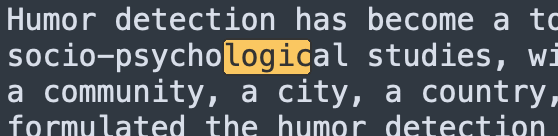

So off the bat, some of the results will not be relevant to our review

# Get wrod clouds by decade

In [2]:
df = pd.read_csv('../../ACL/anthology+abstracts.csv')

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (14,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns

Index(['url', 'publisher', 'address', 'year', 'month', 'editor', 'title',
       'ENTRYTYPE', 'ID', 'pages', 'booktitle', 'author', 'abstract', 'doi',
       'volume', 'journal', 'language', 'number', 'isbn', 'note'],
      dtype='object')

In [61]:
dft = df[['abstract','year']]

In [14]:
# dft['text'] = dft['title'].astype(str) +" "+ dft['abstract'].astype(str)

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
import matplotlib.pyplot as plt
plt.hist(dft['year'])

(array([   63.,   189.,   234.,   467.,  1451.,  3142.,  5268., 10128.,
        19497., 34146.]),
 array([1952., 1959., 1966., 1973., 1980., 1987., 1994., 2001., 2008.,
        2015., 2022.]),
 <BarContainer object of 10 artists>)

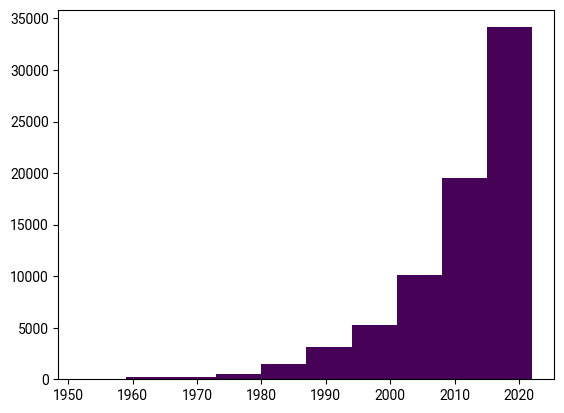

In [33]:
plt.show()

In [34]:
dft.groupby('year').count().reset_index()

,year,text
0,1952,26
1,1956,11
2,1957,26
3,1960,81
4,1961,39
...,...,...
56,2018,4626
57,2019,4980
58,2020,7139
59,2021,6869


In [6]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')

# import file

In [35]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from wordcloud import WordCloud
import utils
import umap
import hdbscan
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/neuro-symbolic-AI/neuro-symbolic-ai-systematic-review/Working-Files/utils.py'>

defaultdict(<class 'str'>, {'nan': 1.0})


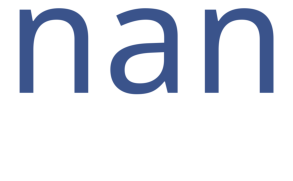

In [63]:
ap=dft[(dft['year']<1960)]
a_abstracts=list(ap['abstract'].astype(str))
text=utils.getTFIDF(a_abstracts,top_n=100,mindf=0.1,maxdf=5.0)
print(text)
utils.drawCloud(text,max_words=100,figsize=(5,10),raw=False, title="1950s\n----------\n",save=True,path='images/1950.svg')

defaultdict(<class 'str'>, {'nan': 1.0})


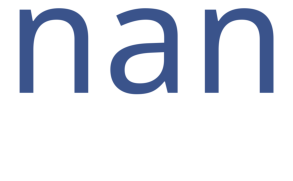

In [65]:
ap=dft[(dft['year']>=1960)&(dft['year']<1970)]
a_abstracts=list(ap['abstract'].astype(str))
text=utils.getTFIDF(a_abstracts,top_n=100,mindf=0.1,maxdf=1.0)
print(text)
utils.drawCloud(text,max_words=100,figsize=(5,10),raw=False, title="1960s\n----------\n",save=True,path='images/1960.svg')

defaultdict(<class 'str'>, {'nan': 1.0, 'officers': 0.0, 'personal': 0.0, 'institute': 0.0, 'ashington': 0.0, 'literary': 0.0, 'information': 0.0, 'linguistic': 0.0, 'jr': 0.0, 'acm': 0.0, 'donald walker': 0.0, 'papers': 0.0, 'international': 0.0, 'indexing': 0.0, 'project': 0.0, 'james': 0.0, 'seminar': 0.0, 'science': 0.0, 'language': 0.0, 'association': 0.0, 'report': 0.0, 'nsf': 0.0, 'asis': 0.0, 'new': 0.0, '1977': 0.0, 'ashington report': 0.0, 'mt': 0.0, 'acl': 0.0, 'new journal': 0.0, 'coling': 0.0, 'ajcl': 0.0, '76': 0.0, 'bibliography': 0.0, 'journal': 0.0, 'john': 0.0, '1978': 0.0, 'afips ashington': 0.0, 'data': 0.0, 'research': 0.0, 'processing': 0.0, 'congress': 0.0, 'annual': 0.0, 'computer conference': 0.0, 'computer': 0.0, 'conferences': 0.0, 'program': 0.0, 'walker': 0.0, '1976': 0.0, 'notes': 0.0, 'dr': 0.0, 'systems': 0.0, 'conference': 0.0, 'nfais': 0.0, 'current bibliography': 0.0, 'linguistics': 0.0, 'national': 0.0, 'afips': 0.0, 'semantics': 0.0, 'personal notes

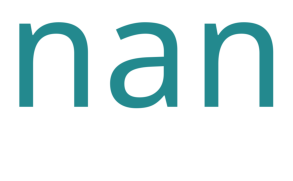

In [66]:
ap=dft[(dft['year']>=1970)&(dft['year']<1980)]
a_abstracts=list(ap['abstract'].astype(str))
text=utils.getTFIDF(a_abstracts,top_n=100,mindf=0.01,maxdf=5.0)
print(text)
utils.drawCloud(text,max_words=100,figsize=(5,10),raw=False, title="1970s\n----------\n",save=True,path='images/1970.svg')

defaultdict(<class 'str'>, {'nan': 1.0, 'like': 0.0, 'order': 0.0, 'instead': 0.0, 'information': 0.0, 'classifier': 0.0, 'evaluating': 0.0, 'usually': 0.0, 'extraction': 0.0, 'conversations': 0.0, 'pair': 0.0, 'space': 0.0, 'applications': 0.0, 'short': 0.0, 'training data': 0.0, 'real world': 0.0, 'alignment': 0.0, 'presents': 0.0, 'complexity': 0.0, 'language pairs': 0.0, 'detection': 0.0, 'syntactic': 0.0, 'predict': 0.0, 'achieve': 0.0, 'way': 0.0, 'learn': 0.0, 'improve': 0.0, 'performs': 0.0, 'dans': 0.0, 'proposed method': 0.0, 'designed': 0.0, 'paper propose': 0.0, 'users': 0.0, 'evaluation': 0.0, 'error': 0.0, 'extend': 0.0, 'unsupervised': 0.0, 'incorporating': 0.0, 'contextual': 0.0, 'detecting': 0.0, 'rules': 0.0, 'comprehensive': 0.0, 'language': 0.0, 'challenges': 0.0, 'outperform': 0.0, 'approaches': 0.0, 'second': 0.0, 'additional': 0.0, 'conversation': 0.0, 'test': 0.0, 'real': 0.0, 'languages': 0.0, 'useful': 0.0, 'inter': 0.0, 'contrast': 0.0, 'encoder decoder': 0.0

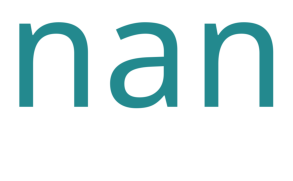

In [67]:
ap=dft[(dft['year']>=2010)&(dft['year']<2023)]
a_abstracts=list(ap['abstract'].astype(str))
text=utils.getTFIDF(a_abstracts,top_n=100,mindf=0.01,maxdf=5.0)
print(text)
utils.drawCloud(text,max_words=100,figsize=(5,10),raw=False, title="1970s\n----------\n",save=True,path='images/2010.svg')

In [68]:
text

defaultdict(str,
            {'nan': 1.0,
             'like': 0.0,
             'order': 0.0,
             'instead': 0.0,
             'information': 0.0,
             'classifier': 0.0,
             'evaluating': 0.0,
             'usually': 0.0,
             'extraction': 0.0,
             'conversations': 0.0,
             'pair': 0.0,
             'space': 0.0,
             'applications': 0.0,
             'short': 0.0,
             'training data': 0.0,
             'real world': 0.0,
             'alignment': 0.0,
             'presents': 0.0,
             'complexity': 0.0,
             'language pairs': 0.0,
             'detection': 0.0,
             'syntactic': 0.0,
             'predict': 0.0,
             'achieve': 0.0,
             'way': 0.0,
             'learn': 0.0,
             'improve': 0.0,
             'performs': 0.0,
             'dans': 0.0,
             'proposed method': 0.0,
             'designed': 0.0,
             'paper propose': 0.0,
             '